In [55]:
%load_ext autoreload
%autoreload 2

# Get parent directory and add to sys.path
import os
import sys

parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

# Require ipympl
%matplotlib widget 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
# MPC import
import numpy as np
import matplotlib.pyplot as plt
from LinearMPC.MPCVelControl import MPCVelControl
from src.rocket import Rocket
from src.vel_rocket_vis import RocketVis

rocket_obj_path = os.path.join(parent_dir, "Cartoon_rocket.obj")
rocket_params_path = os.path.join(parent_dir, "rocket.yaml")

In [60]:
Ts = 0.05
sim_time = 7.0
H = 5.0
x0 = np.array([             # initial state for testing (12 states)
    0, 0, 0,                # angular velocities wx, wy, wz
    0, 0, 0,                # Euler angles α, β, γ
    0, 0, -2,                # velocities vx, vy, vz 
    0, 3, 10                 # position x, y, z
])  # initial state

rocket = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)
mpc = MPCVelControl().new_controller(rocket, Ts, H)


t_cl, x_cl, u_cl, t_ol, x_ol, u_ol, _ = rocket.simulate_control(
    mpc, sim_time, H, x0, method="linear"
)


vis = RocketVis(rocket, rocket_obj_path)
vis.anim_rate = 1.0
vis.animate(t_cl[:-1], x_cl[:, :-1], u_cl, T_ol=t_ol[..., :-1], X_ol=x_ol, U_ol=u_ol);


Simulating time 0.00: 
Simulating time 0.05: 
Simulating time 0.10: 
Simulating time 0.15: 
Simulating time 0.20: 
Simulating time 0.25: 
Simulating time 0.30: 
Simulating time 0.35: 
Simulating time 0.40: 
Simulating time 0.45: 
Simulating time 0.50: 
Simulating time 0.55: 
Simulating time 0.60: 
Simulating time 0.65: 
Simulating time 0.70: 
Simulating time 0.75: 
Simulating time 0.80: 
Simulating time 0.85: 
Simulating time 0.90: 
Simulating time 0.95: 
Simulating time 1.00: 
Simulating time 1.05: 
Simulating time 1.10: 
Simulating time 1.15: 
Simulating time 1.20: 
Simulating time 1.25: 
Simulating time 1.30: 
Simulating time 1.35: 
Simulating time 1.40: 
Simulating time 1.45: 
Simulating time 1.50: 
Simulating time 1.55: 
Simulating time 1.60: 
Simulating time 1.65: 
Simulating time 1.70: 
Simulating time 1.75: 
Simulating time 1.80: 
Simulating time 1.85: 
Simulating time 1.90: 
Simulating time 1.95: 
Simulating time 2.00: 
Simulating time 2.05: 
Simulating time 2.10: 
Simulating 

AppLayout(children=(HBox(children=(Play(value=0, description='Press play', max=139, step=2), IntSlider(value=0…

Text(0.5, 1.0, 'Xf_y proj (ωx, α)')

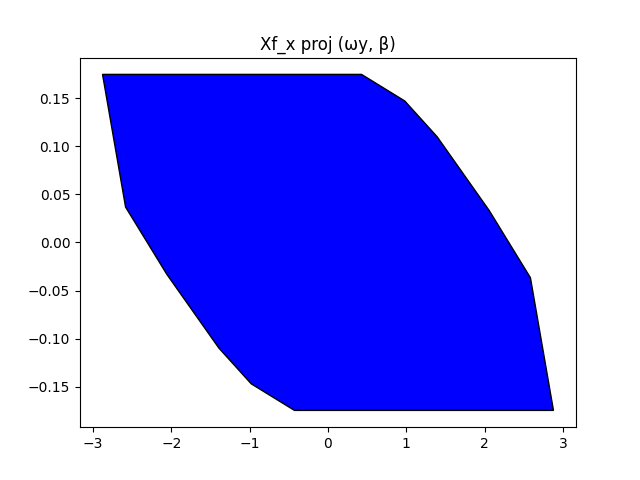

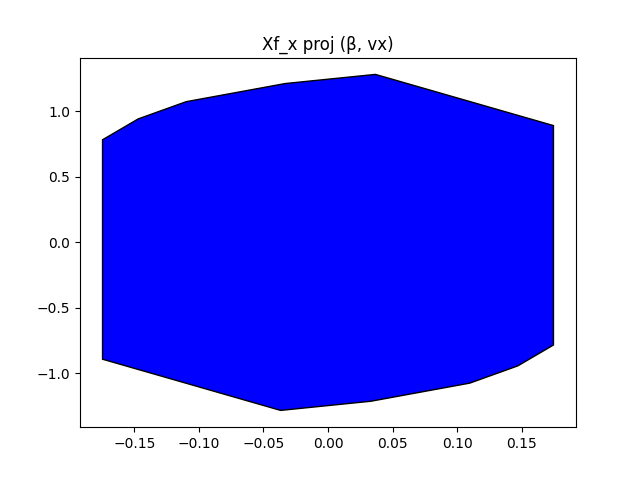

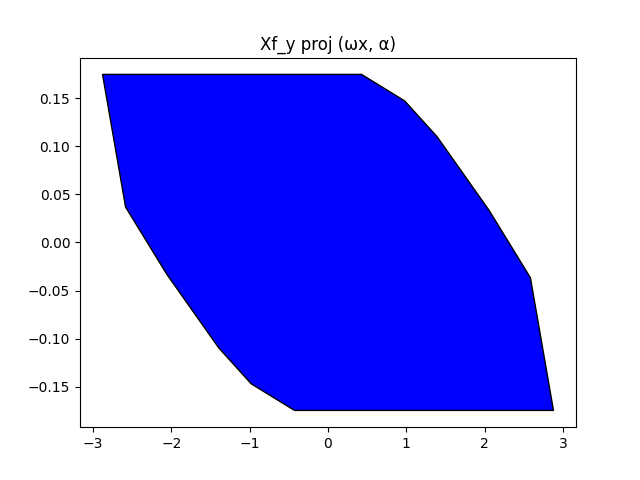

In [58]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
mpc.mpc_x.Xf.projection(dims=(0,1)).plot(ax)
ax.set_title("Xf_x proj (ωy, β)")

fig, ax = plt.subplots()
mpc.mpc_x.Xf.projection(dims=(1,2)).plot(ax)
ax.set_title("Xf_x proj (β, vx)")

fig, ax = plt.subplots()
mpc.mpc_y.Xf.projection(dims=(0,1)).plot(ax)
ax.set_title("Xf_y proj (ωx, α)")


Text(0.5, 1.0, 'Xf_roll (ωz, γ)')

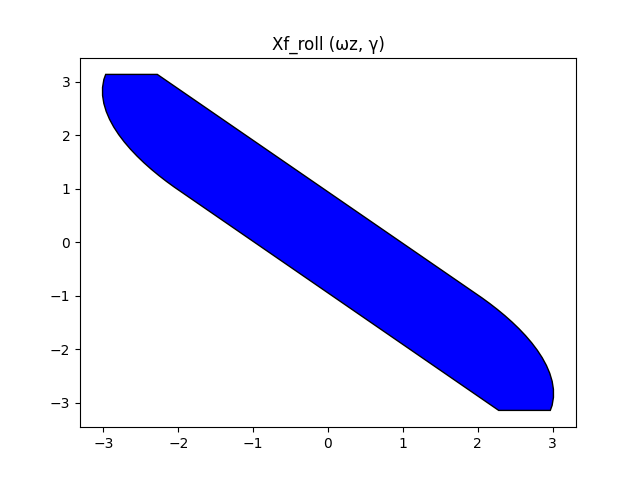

In [59]:
fig, ax = plt.subplots()
mpc.mpc_roll.Xf.plot(ax)
ax.set_title("Xf_roll (ωz, γ)")
